In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import random
from preparatory_functions import *
from training_functions import *
from error_functions import *
from autoencoder import AutoEncoder
import torch
import torch.nn as nn 
import logging
import gc
# erase disk memory so we re-train the same each time 
gc.collect()
seed = 100
torch.manual_seed(seed)
logging.basicConfig(level=logging.INFO)

In [2]:
# load & sample data
dataset_zip = np.load('./dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz')
imgs_full = dataset_zip['imgs']
sample_imgs = random.sample(list(imgs_full), 1000)

In [3]:
transformed_baseline_imgs = transform_background_colors(sample_imgs)
anomaly_imgs = np.array([create_anomalous_dataset(i) for i in transformed_baseline_imgs])
transformed_images = data_transformations(transformed_baseline_imgs)
transformed_anomaly_images = data_transformations(anomaly_imgs)

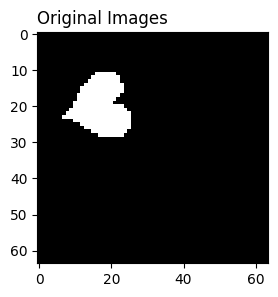

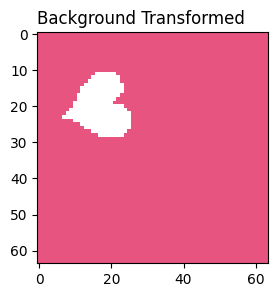

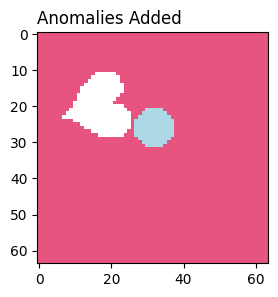

In [15]:
show_images_grid(sample_imgs, 1, title='Original Images')
show_images_grid(transformed_baseline_imgs, 1, title='Background Transformed')
show_images_grid(anomaly_imgs, 1, title='Anomalies Added')

In [30]:
transformed_anomaly_images[0].shape

torch.Size([3, 64, 64])

In [16]:
def conv_transpose1d_output_size(H_in, stride, padding, dilation, kernel_size, output_padding):
    """
    Compute the output size of a 1D transposed convolution.

    Parameters
    ----------
    H_in : int
        Input size (length).
    stride : int
        Stride of the convolution.
    padding : int
        Padding applied to the input.
    dilation : int
        Dilation factor of the kernel.
    kernel_size : int
        Size of the convolution kernel.
    output_padding : int
        Additional size added to the output shape.

    Returns
    -------
    int
        The computed output size.
    """
    return (H_in - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1

print(conv_transpose1d_output_size(32, 2, 1, 1, 4, 0))

64


In [4]:
data_loaders = torch.utils.data.DataLoader(transformed_images, batch_size=20, shuffle=False)
data_loaders_anomaly = torch.utils.data.DataLoader(transformed_anomaly_images, batch_size=20, shuffle=False)

In [5]:
model = AutoEncoder(channels=3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
logging.info('Training start!')

training_outputs, trained_model = training_loop(epochs=15, data_loader=data_loaders, model=model, criterion=criterion, optimizer=optimizer)




INFO:root:Training start!


Epoch 0 loss: 0.2870176136493683
Epoch 1 loss: 0.2693179249763489
Epoch 2 loss: 0.24067135155200958
Epoch 3 loss: 0.2172144651412964
Epoch 4 loss: 0.1996924877166748
Epoch 5 loss: 0.17439645528793335
Epoch 6 loss: 0.13445056974887848
Epoch 7 loss: 0.08697215467691422
Epoch 8 loss: 0.04741967096924782
Epoch 9 loss: 0.022665753960609436
Epoch 10 loss: 0.012221899814903736
Epoch 11 loss: 0.00848444178700447
Epoch 12 loss: 0.006661598104983568
Epoch 13 loss: 0.00558472191914916
Epoch 14 loss: 0.004835708066821098


In [7]:
predictions = eval_loop(model=trained_model, data_loader=data_loaders)
anomaly_predictions = eval_loop(model=trained_model, data_loader=data_loaders_anomaly)
latent_space_predictions = eval_loop(model=trained_model, data_loader=data_loaders, latent_space=True)
latent_space_predictions_anomaly = eval_loop(model=trained_model, data_loader=data_loaders_anomaly, latent_space=True)


In [8]:
kde_results = {}
h = 0.5
average_recond_error, average_density, stdev_recon_error, stdev_density, density_list, recon_error_list = calc_density_and_recon_error(dataloader=data_loaders, 
                                                                                                                                    model=trained_model, 
                                                                                                                                    latent_space_images=latent_space_predictions,
                                                                                                                                    height=h
                                                                                                                                    )
average_recond_error_anomaly, average_density_anomaly, stdev_recon_error_anomaly, stdev_density_anomaly, density_list_anomaly, recon_error_list_anomaly = calc_density_and_recon_error(dataloader=data_loaders_anomaly, 
                                                                                                                                                                                        model=trained_model, 
                                                                                                                                                                                        latent_space_images=latent_space_predictions_anomaly,
                                                                                                                                                                                        height=h
                                                                                                                                                                                        )

kde_results[f'height_{h}'] = {'average_recond_error_anomaly': average_recond_error_anomaly,
                                'average_density_anomaly': average_density_anomaly, 
                                'stdev_recon_error_anomaly': stdev_recon_error_anomaly,
                                'stdev_density_anomaly': stdev_density_anomaly,
                                'density_list_anomaly': density_list_anomaly, 
                                'recon_error_list_anomaly': recon_error_list_anomaly,
                                'average_recond_error': average_recond_error,
                                'average_density': average_density, 
                                'stdev_recon_error': stdev_recon_error,
                                'stdev_density': stdev_density,
                                'density_list': density_list, 
                                'recon_error_list': recon_error_list}



In [9]:
average_recond_error

np.float64(0.0011762907286267635)

In [10]:
average_recond_error_anomaly 

np.float64(0.002223365221483787)

In [11]:
# next steps is to create the for-loop and show the accuracy of the images if they've been detected as anomally or not 
correct = 0
incorrect = 0 
index = 0
error_interval = 0.0005

h= 0.5
anomalies_detected = 0
anomalies_missed = 0
normal_image_detected = 0
normal_image_missed = 0
# using the average reconstruction error for anomalies you can check whether or not it falls above or below the average error
for error in kde_results[f'height_{h}']['recon_error_list_anomaly']:
    if error >= average_recond_error_anomaly - error_interval:
        anomalies_detected += 1
        tag = 'anomaly'
    else: 
        anomalies_missed += 1 
        tag = 'non anomaly'


for error in kde_results[f'height_{h}']['recon_error_list']:
    if error >= average_recond_error_anomaly - error_interval:
        normal_image_missed += 1 
        tag = 'not normal'
    else: 
        normal_image_detected += 1
        tag = 'normal'

print(f'-----------------results for height {h}-------------------')
print(f'true positives {normal_image_detected}')
print(f'false negatives {normal_image_missed}')
print(f'true negative {anomalies_detected}')
print(f'false positive {anomalies_missed}')



-----------------results for height 0.5-------------------
true positives 951
false negatives 50
true negative 670
false positive 331


C:\Users\jonny\AppData\Local\Temp\ipykernel_15848\3791025253.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_anomalies, shade=True, color='red', label='Anomalies')
C:\Users\jonny\AppData\Local\Temp\ipykernel_15848\3791025253.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_normals, shade=True, color='blue', label='Normal')


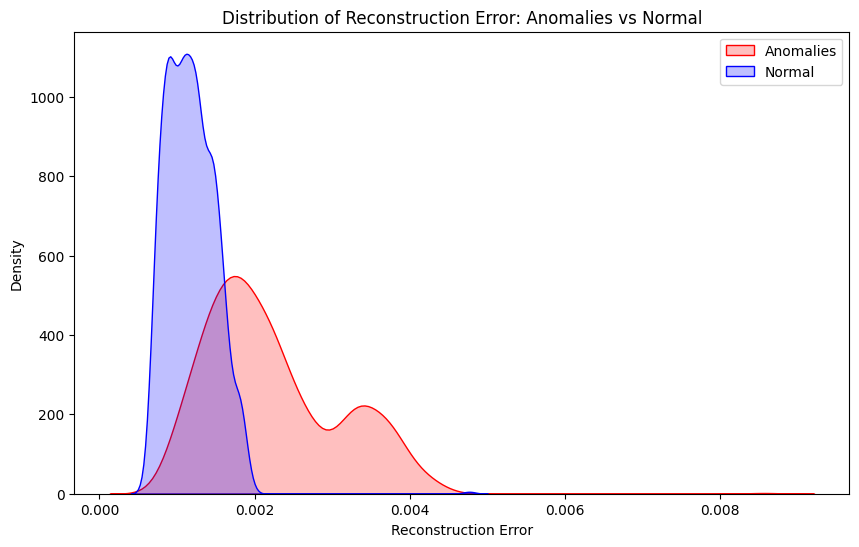

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
h = 0.5
# Example lists: replace with your actual data
recon_error_anomalies = kde_results[f'height_{h}']['recon_error_list_anomaly']
recon_error_normals = kde_results[f'height_{h}']['recon_error_list']

# Create a figure
plt.figure(figsize=(10, 6))

# Plot KDE for anomalies
sns.kdeplot(recon_error_anomalies, shade=True, color='red', label='Anomalies')

# # Plot KDE for normal images
sns.kdeplot(recon_error_normals, shade=True, color='blue', label='Normal')

# Optionally, also show histograms
# plt.hist(recon_error_anomalies, bins=30, alpha=0.3, color='red')
# plt.hist(recon_error_normals, bins=30, alpha=0.3, color='blue')

# Add labels and title
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.title('Distribution of Reconstruction Error: Anomalies vs Normal')
plt.legend()

# Show plot
plt.show()


C:\Users\jonny\AppData\Local\Temp\ipykernel_15848\4046394153.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_anomalies, shade=True, color='red', label='Anomalies')
C:\Users\jonny\AppData\Local\Temp\ipykernel_15848\4046394153.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recon_error_normals, shade=True, color='blue', label='Normal')


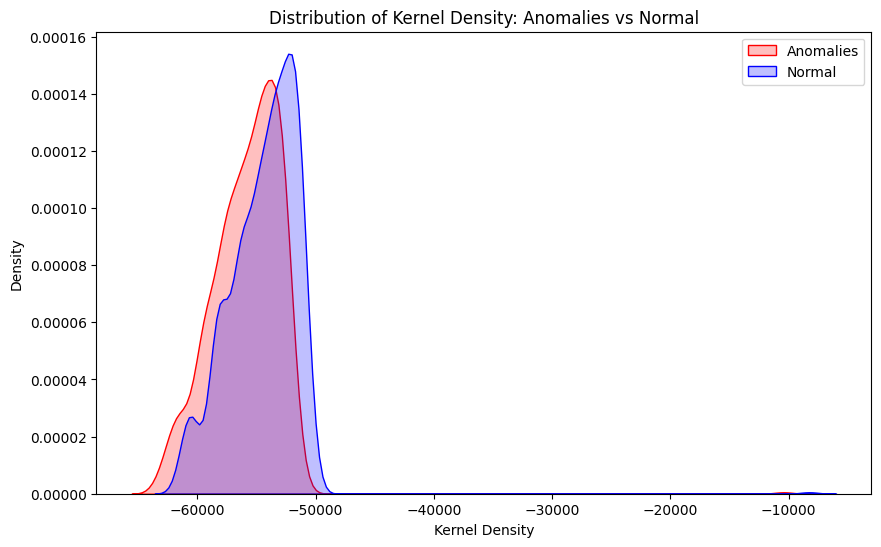

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

h = 0.5
recon_error_anomalies = kde_results[f'height_{h}']['density_list_anomaly']
recon_error_normals = kde_results[f'height_{h}']['density_list']

# Create a figure
plt.figure(figsize=(10, 6))

# Plot KDE for anomalies
sns.kdeplot(recon_error_anomalies, shade=True, color='red', label='Anomalies')

# # Plot KDE for normal images
sns.kdeplot(recon_error_normals, shade=True, color='blue', label='Normal')

# Optionally, also show histograms
# plt.hist(recon_error_anomalies, bins=30, alpha=0.3, color='red')
# plt.hist(recon_error_normals, bins=30, alpha=0.3, color='blue')

# Add labels and title
plt.xlabel('Kernel Density')
plt.ylabel('Density')
plt.title('Distribution of Kernel Density: Anomalies vs Normal')
plt.legend()

# Show plot
plt.show()


C:\Users\jonny\AppData\Local\Temp\ipykernel_15848\3328012840.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pixels_anomalies, shade=True, color='red', label='Anomalies')
C:\Users\jonny\AppData\Local\Temp\ipykernel_15848\3328012840.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pixels_normals, shade=True, color='blue', label='Normal')


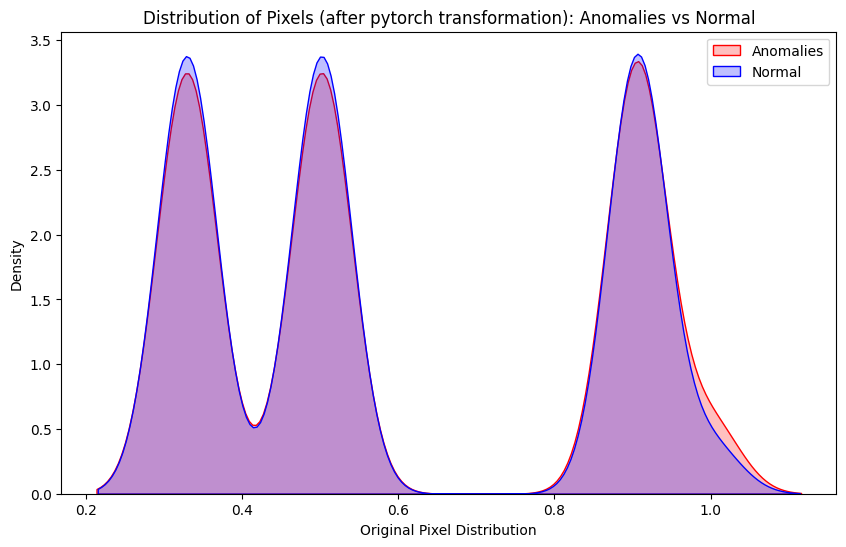

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

h = 0.5
pixels_anomalies = transformed_anomaly_images[0].reshape(-1)
pixels_normals = transformed_images[0].reshape(-1)

# Create a figure
plt.figure(figsize=(10, 6))

# Plot pixels for anomalies
sns.kdeplot(pixels_anomalies, shade=True, color='red', label='Anomalies')

# # Plot pixels for normal images
sns.kdeplot(pixels_normals, shade=True, color='blue', label='Normal')

# Add labels and title
plt.xlabel('Original Pixel Distribution')
plt.ylabel('Density')
plt.title('Distribution of Pixels (after pytorch transformation): Anomalies vs Normal')
plt.legend()

# Show plot
plt.show()

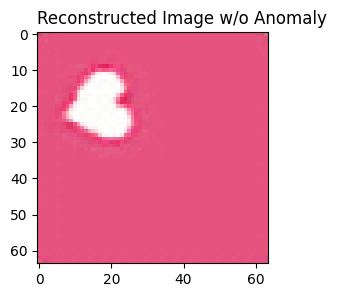

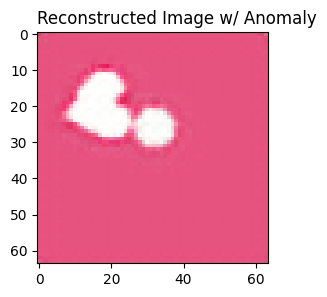

In [31]:
show_images_grid(predictions, 1, 'Reconstructed Image w/o Anomaly')
show_images_grid(anomaly_predictions, 1,'Reconstructed Image w/ Anomaly')